## Experiment DL learning with custom embedding and simple Dense layer
Even if the training set is too small to produce a representative word embedding, this notebook illustrates an experiment to have a rough idea on the resulting score with such embedding choice

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import vizu

In [11]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')
XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)

In [29]:
# hyper params
num_classes = 51
patience=20
vocabulary_size = 10000
sequence_length = 30
hidden_dims = 100
embedding_out_dims = 300
dropout_rate=0.2
num_epochs= 100

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

### Build the neural network
The NN is composed of 3 layers:
* custom embeddding layer
* fully connected layer to learn classification with relu activation
* decision layer with sotfmax activation

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

import tensorflow as tf
#config = tf.ConfigProto(device_count={"CPU": 32})
config = tf.ConfigProto()
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

model = Sequential()
model.add(Embedding(vocabulary_size , embedding_out_dims, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 30, 300)           3000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               900100    
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 51)                5151      
Total params: 3,905,251
Trainable params: 3,905,251
Non-trainable params: 0
_________________________________________________________________


### Train the network

In [15]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [31]:
import keras.utils

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

model.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.1,
    epochs=num_epochs,
    callbacks = [call_back_early_stopping])

Train on 6140 samples, validate on 683 samples
Epoch 1/100
6140/6140 [==============================] - 3s 471us/step - loss: 3.0889 - acc: 0.2446 - val_loss: 2.7213 - val_acc: 0.3426
Epoch 2/100
6140/6140 [==============================] - 2s 336us/step - loss: 2.0881 - acc: 0.4792 - val_loss: 2.0476 - val_acc: 0.4919
Epoch 3/100
6140/6140 [==============================] - 2s 335us/step - loss: 1.0540 - acc: 0.7513 - val_loss: 1.7801 - val_acc: 0.5608
Epoch 4/100
6140/6140 [==============================] - 2s 341us/step - loss: 0.4463 - acc: 0.9005 - val_loss: 1.7964 - val_acc: 0.5871
Epoch 5/100
6140/6140 [==============================] - 2s 339us/step - loss: 0.2177 - acc: 0.9562 - val_loss: 1.8756 - val_acc: 0.5959
Epoch 6/100
6140/6140 [==============================] - 2s 334us/step - loss: 0.1188 - acc: 0.9770 - val_loss: 1.9686 - val_acc: 0.5930
Epoch 7/100
6140/6140 [==============================] - 2s 336us/step - loss: 0.0798 - acc: 0.9862 - val_loss: 2.0310 - val_acc: 0

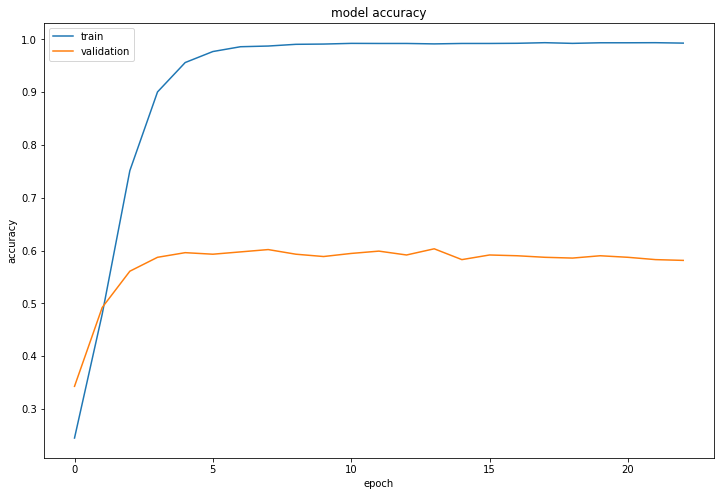

In [32]:
%matplotlib inline
vizu.plot_keras_model_learning_curve(model.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.75      0.43      0.55        35
          1       0.00      0.00      0.00         4
          2       1.00      0.20      0.33         5
          3       0.00      0.00      0.00         1
          4       0.80      0.73      0.76        11
          5       0.50      0.22      0.31        18
          6       0.75      0.75      0.75         4
          7       0.00      0.00      0.00         1
          8       0.89      0.68      0.77        25
          9       0.50      0.14      0.22         7
         10       0.62      0.42      0.50        12
         11       0.47      0.33      0.39        27
         12       0.12      0.17      0.14         6
         13       0.27      0.25      0.26        12
         14       0.32      0.45      0.38        42
         15       0.33      0.25      0.29         4
         16       0.67      0.67      0.67         3
         17       0.50      0.50      0.50   

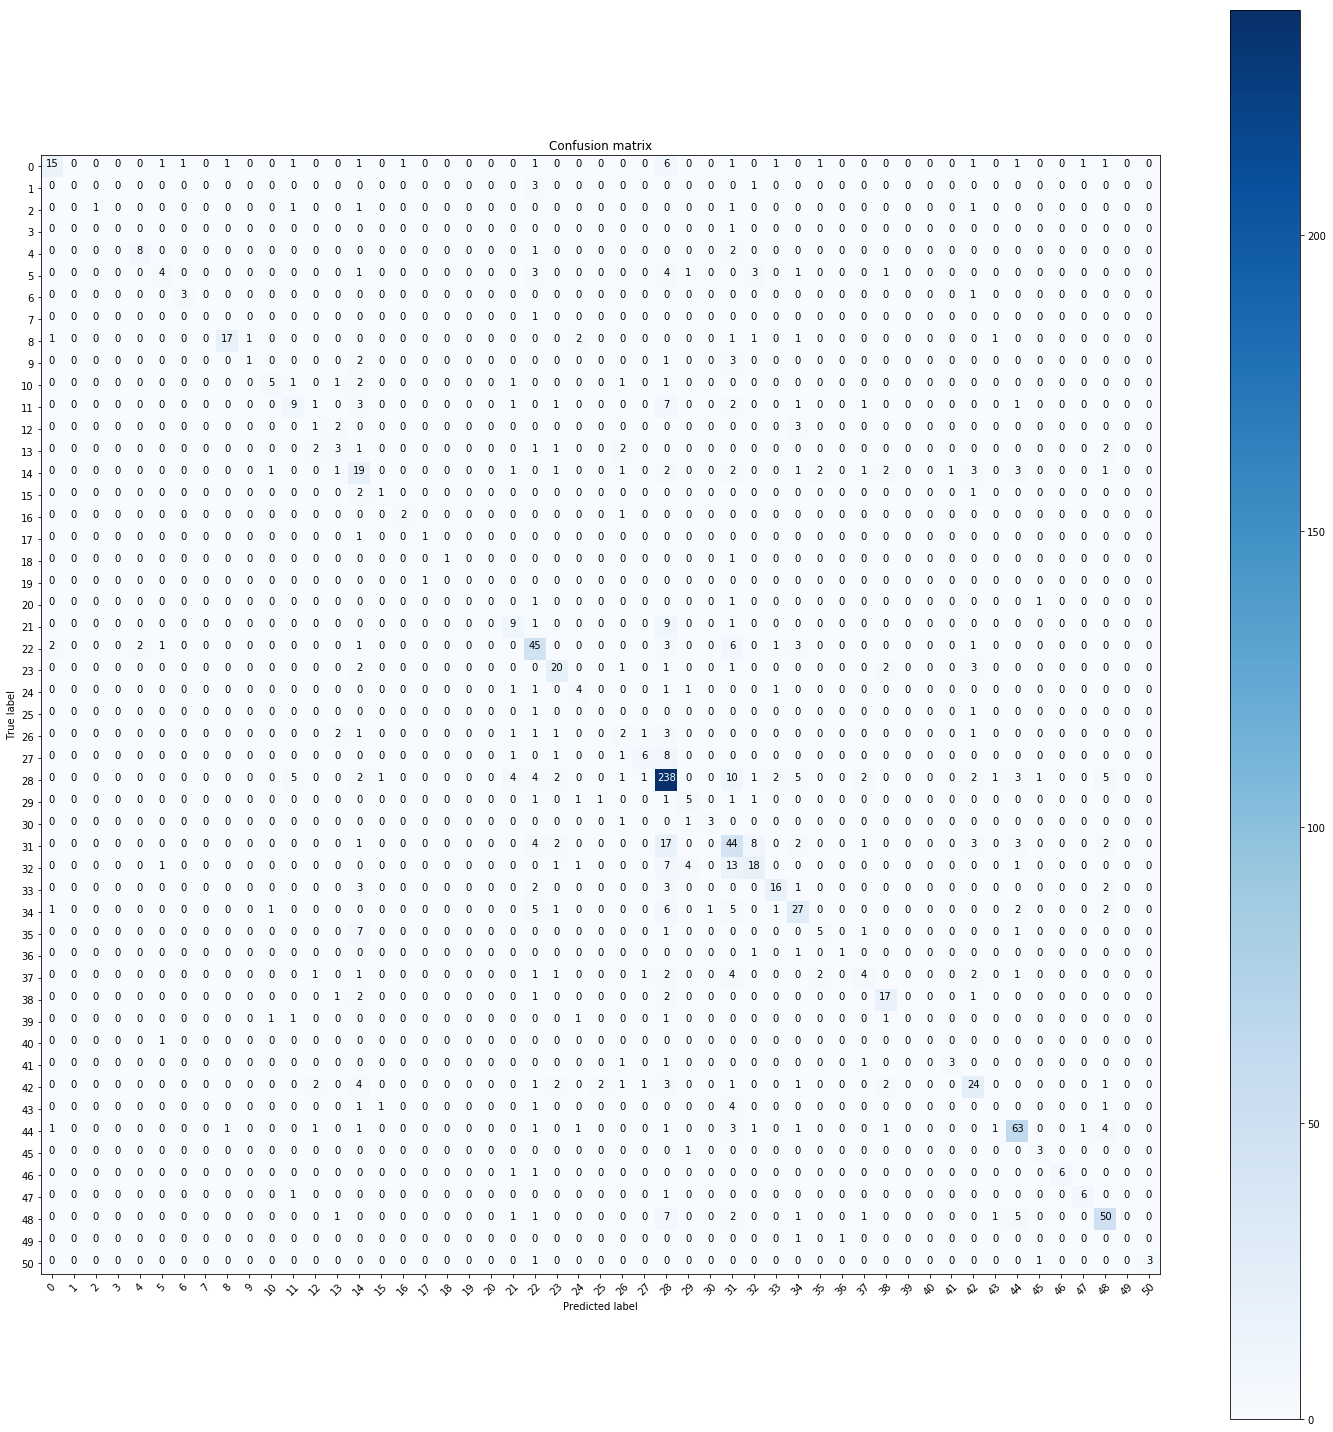

In [18]:
import sklearn
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()


The model is overfitting rapidly beyond 5 epochs but no observed accuracy improvement on validation set (get rapidly stationary accuracy aounrd 62%)